In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

N_EPOCHES = 20

# Transfer learning 101

In this notebook we will be using the maleria dataset: https://lhncbc.nlm.nih.gov/publication/pub9932
We will just load the data and resize it to 128x128 without looking too much into pre-processing or hyper parameter tuning given it is outside the scope of this session.

In [2]:
from get_dataset import DataSetGenerator
dataset_generator = DataSetGenerator(
    data_location=r"D:\data\malaria_dataset",
    batch_size=64,
    patch_dimension=128,
    image_type="png")
train_ds, val_ds = dataset_generator.get_datasets()

## Let's have a look at the data we are dealing with

We will vizualize 64 random images and its labels just to see what we are dealing with.
These image already have some data augmentation.

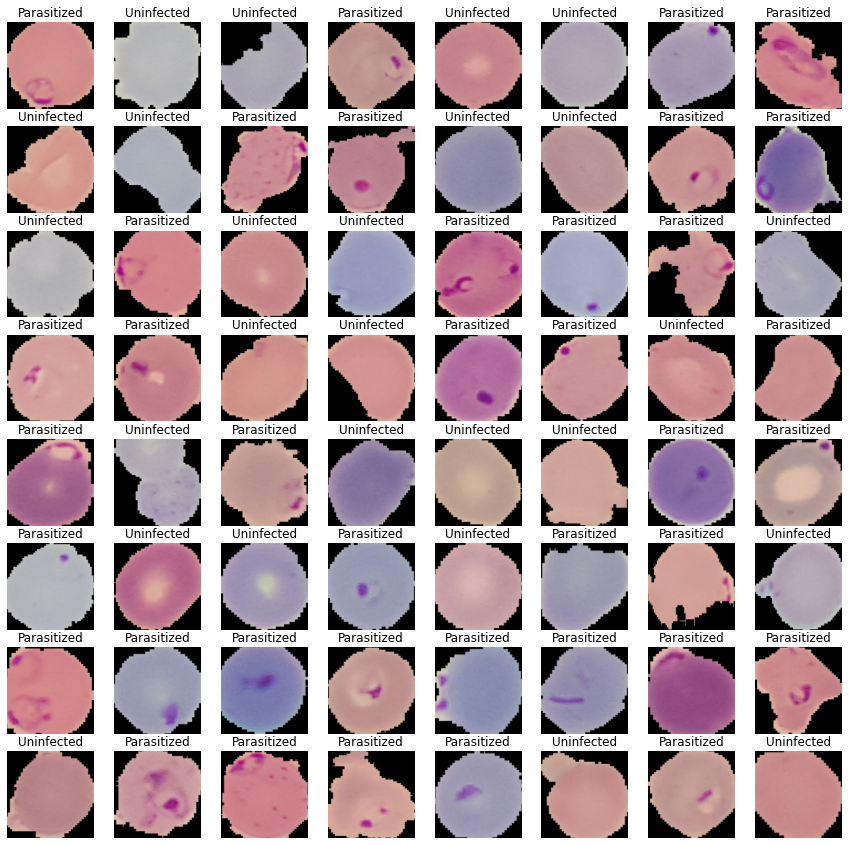

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(15,15))
for images, labels in train_ds.take(1):
  for i in range(64):
    ax = plt.subplot(8, 8, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(dataset_generator.class_names[np.argmax(labels[i])])
    plt.axis("off")
plt.show()

## Getting the model
We will download the [EfficientNet B0](https://arxiv.org/abs/1905.11946). This is a network optimized to have as little FLOPS for the maximum accuracy. The network can be downloaded with and without pre-trained weights. The pre-trained weights are trained on the [imageNet Challange](http://image-net.org/). These are nature image made with normale RGB camera's of everyday objects (not just food).

In this notebook we are gone to see what a difference it makes to have pre-trained weights VS random weights.

The model that is loaded is without a head because we only have 2 classes not thousands.

In [4]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Model

def create_model(weights="imagenet"):
    n_classes = len(dataset_generator.class_names)
    pre_trained_model = EfficientNetB0(include_top=False, weights=weights)

    input_layer = pre_trained_model.input
    max_pool = MaxPooling2D((4, 4))(pre_trained_model.output)

    dense1 = Dense(n_classes, activation="softmax")(max_pool)
    flat = Flatten()(dense1)

    model = Model(input_layer, flat)

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy']
    )
    return model

## Training with random weights
We train the model with randomly generated weights as a baseline to compare our pre-trained network against.

In [5]:
model_no_pretrain = create_model(None)
history_no_pretrained = model_no_pretrain.fit(train_ds,
  validation_data=val_ds,
  epochs=N_EPOCHES
)

Epoch 1/20
302/302 [==============================] - 144s 476ms/step - loss: 0.9020 - accuracy: 0.5776 - val_loss: 0.6833 - val_accuracy: 0.5178
Epoch 2/20
302/302 [==============================] - 63s 207ms/step - loss: 0.6449 - accuracy: 0.7177 - val_loss: 5.8048 - val_accuracy: 0.5440
Epoch 3/20
302/302 [==============================] - 63s 209ms/step - loss: 0.2901 - accuracy: 0.9113 - val_loss: 0.7692 - val_accuracy: 0.6219
Epoch 4/20
302/302 [==============================] - 63s 210ms/step - loss: 0.1868 - accuracy: 0.9469 - val_loss: 0.3272 - val_accuracy: 0.8702
Epoch 5/20
302/302 [==============================] - 64s 210ms/step - loss: 0.2777 - accuracy: 0.9363 - val_loss: 0.3115 - val_accuracy: 0.8931
Epoch 6/20
302/302 [==============================] - 64s 211ms/step - loss: 0.2009 - accuracy: 0.9456 - val_loss: 0.3930 - val_accuracy: 0.8321
Epoch 7/20
302/302 [==============================] - 64s 212ms/step - loss: 0.1746 - accuracy: 0.9548 - val_loss: 0.1660 - val_a

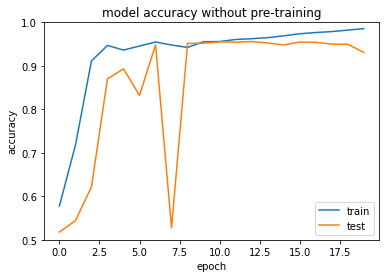

In [6]:
# summarize history for accuracy
plt.plot(history_no_pretrained.history['accuracy'])
plt.plot(history_no_pretrained.history['val_accuracy'])
plt.title('model accuracy without pre-training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0.5,1])
plt.legend(['train', 'test'], loc='lower right')
plt.show()

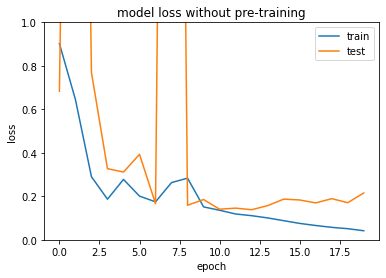

In [7]:
# summarize history for loss
plt.plot(history_no_pretrained.history['loss'])
plt.plot(history_no_pretrained.history['val_loss'])
plt.title('model loss without pre-training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## training with pre-trained weights
Next up we load a new model but this time with pretrained weights.
Everything else about the model is exactly the same.

In [8]:
model_with_pretrain = create_model("imagenet")
history_pretrained = model_with_pretrain.fit(train_ds,
  validation_data=val_ds,
  epochs=N_EPOCHES
)

Epoch 1/20
302/302 [==============================] - 60s 200ms/step - loss: 0.1922 - accuracy: 0.9468 - val_loss: 0.1114 - val_accuracy: 0.9656
Epoch 2/20
302/302 [==============================] - 59s 197ms/step - loss: 0.0967 - accuracy: 0.9678 - val_loss: 0.0964 - val_accuracy: 0.9677
Epoch 3/20
302/302 [==============================] - 60s 197ms/step - loss: 0.0713 - accuracy: 0.9756 - val_loss: 0.1181 - val_accuracy: 0.9666
Epoch 4/20
302/302 [==============================] - 59s 196ms/step - loss: 0.0731 - accuracy: 0.9771 - val_loss: 1.6593 - val_accuracy: 0.8512
Epoch 5/20
302/302 [==============================] - 59s 196ms/step - loss: 0.1105 - accuracy: 0.9634 - val_loss: 0.1074 - val_accuracy: 0.9644
Epoch 6/20
302/302 [==============================] - 59s 197ms/step - loss: 0.0709 - accuracy: 0.9741 - val_loss: 0.1247 - val_accuracy: 0.9689
Epoch 7/20
302/302 [==============================] - 60s 197ms/step - loss: 0.0575 - accuracy: 0.9787 - val_loss: 0.1246 - val_ac

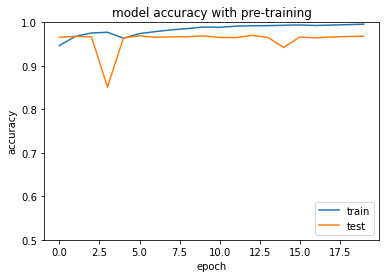

In [9]:
# summarize history for accuracy
plt.plot(history_pretrained.history['accuracy'])
plt.plot(history_pretrained.history['val_accuracy'])
plt.title('model accuracy with pre-training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0.5,1])
plt.legend(['train', 'test'], loc='lower right')
plt.show()

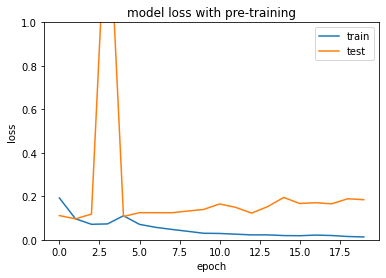

In [10]:
# summarize history for loss
plt.plot(history_pretrained.history['loss'])
plt.plot(history_pretrained.history['val_loss'])
plt.title('model loss with pre-training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Conclusion
We can see the pre-trained model being at a better accuracy and loss for both validation and training after 3 epoch compared to 50 epoch if we don't pre-train.

Be aware that the pre-trained model start overfitting way earlier.

But we can see that even when the dataset domains are futher apart transfer learning still has benefits.